# Autoencoder Alternative Pipeline

1. train, test split
2. normalize fit transform train, transform test
3. X_train, y_train -> scale -> train auto-encoder -> train linear classifier
4. X_test, y_test -> scale -> run though auto-encoder with learned weights -> apply linear classifier

In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import os
sns.set(style="whitegrid")
np.random.seed(203)

data_source_dir = r"/home/jasonchandatascience/Keras/autoencoders/data"

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def GetPath(directory, file):
    return os.path.join(directory, file)

In [5]:
def tsne_plot(x1, y1, name="graph.png", pos="Fraud", neg="Non Fraud"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    
    print(f"shape of X_t is now {X_t.shape}, reduced from 31 variables to just 2")
    sns.set_palette('muted')
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label=neg)
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label=pos)

    plt.legend(loc='best');
    plt.show();

In [3]:
data = pd.read_csv(GetPath(data_source_dir, "creditcard.csv"))

In [4]:
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

In [40]:
data_neg = data[data["Class"] == 0].sample(5000)
data_pos =  data[data["Class"] == 1]

In [41]:
data_merged = pd.concat([data_neg, data_pos])

In [42]:
data_merged["Class"].value_counts()

0    5000
1     492
Name: Class, dtype: int64

In [67]:
y = data_merged["Class"].values
X = data_merged.drop(["Class"], axis =1)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [69]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train.values)
x_scale = scaler.transform(X_train.values)
test_x_scale = scaler.transform(X_test.values)

In [70]:
x_scale.shape

(3844, 30)

In [71]:
test_x_scale = scaler.transform(X_test)

In [72]:
x_norm, x_fraud = x_scale[y_train == 0], x_scale[y_train == 1]

# Building the Autoencoder

In [73]:
## Input Layer

# 30 variables
input_layer = Input(shape=(X_train.shape[1], ))

## Encoder
encoded = Dense(100, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation="relu")(encoded)

## Decoder

decoder = Dense(50, activation="tanh")(encoded)
decoder = Dense(100, activation="tanh")(decoder)

## Output layer
output_layer = Dense(X_train.shape[1], activation="relu")(decoder)

In [74]:
autoencoder = Model(input_layer, output_layer)

In [75]:
autoencoder.compile(optimizer="adadelta", loss="mse")

In [76]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________________


In [77]:
autoencoder.fit(x=x_norm, y=x_norm, epochs=40, shuffle=True, validation_split=0.2)

Train on 2800 samples, validate on 700 samples
Epoch 1/40
2800/2800 [==============================] - 1s 245us/step - loss: 0.1134 - val_loss: 0.0819
Epoch 2/40
2800/2800 [==============================] - 0s 114us/step - loss: 0.0756 - val_loss: 0.0723
Epoch 3/40
2800/2800 [==============================] - 0s 92us/step - loss: 0.0685 - val_loss: 0.0664
Epoch 4/40
2800/2800 [==============================] - 0s 87us/step - loss: 0.0659 - val_loss: 0.0654
Epoch 5/40
2800/2800 [==============================] - 0s 109us/step - loss: 0.0639 - val_loss: 0.0613
Epoch 6/40
2800/2800 [==============================] - 0s 95us/step - loss: 0.0622 - val_loss: 0.0607
Epoch 7/40
2800/2800 [==============================] - 0s 108us/step - loss: 0.0604 - val_loss: 0.0597
Epoch 8/40
2800/2800 [==============================] - 0s 110us/step - loss: 0.0599 - val_loss: 0.0593
Epoch 9/40
2800/2800 [==============================] - 0s 110us/step - loss: 0.0596 - val_loss: 0.0589
Epoch 10/40
2800/280

# Latent Representations

In [78]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [79]:
hidden_representation.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
Total params: 8,150
Trainable params: 8,150
Non-trainable params: 0
_________________________________________________________________


In [80]:
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [85]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print (classification_report(val_y, pred_y))
print (accuracy_score(val_y, pred_y))
print(confusion_matrix(val_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       878
         1.0       1.00      0.69      0.81        83

   micro avg       0.97      0.97      0.97       961
   macro avg       0.99      0.84      0.90       961
weighted avg       0.97      0.97      0.97       961

0.9729448491155047
[[878   0]
 [ 26  57]]


# On test set

In [86]:
test_rep_x = hidden_representation.predict(test_x_scale)

In [100]:
pred_y_test = clf.predict(test_rep_x)

In [92]:
print (classification_report(y_test, pred_y_test))
print (accuracy_score(y_test, pred_y_test))
print(confusion_matrix(y_test, pred_y_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1500
           1       1.00      0.64      0.78       148

   micro avg       0.97      0.97      0.97      1648
   macro avg       0.98      0.82      0.88      1648
weighted avg       0.97      0.97      0.96      1648

0.9672330097087378
[[1500    0]
 [  54   94]]


# T-SNE graphs

## Train set

shape of X_t is now (3844, 2), reduced from 31 variables to just 2


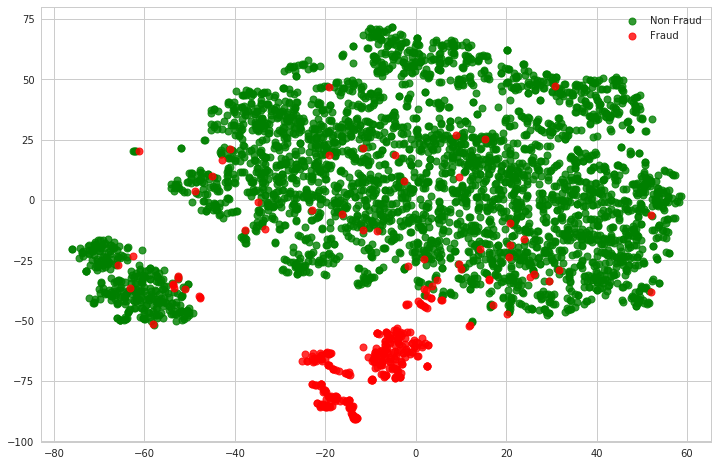

In [94]:
tsne_plot(rep_x, rep_y)

## Test Set

### Ground Truth

shape of X_t is now (1648, 2), reduced from 31 variables to just 2


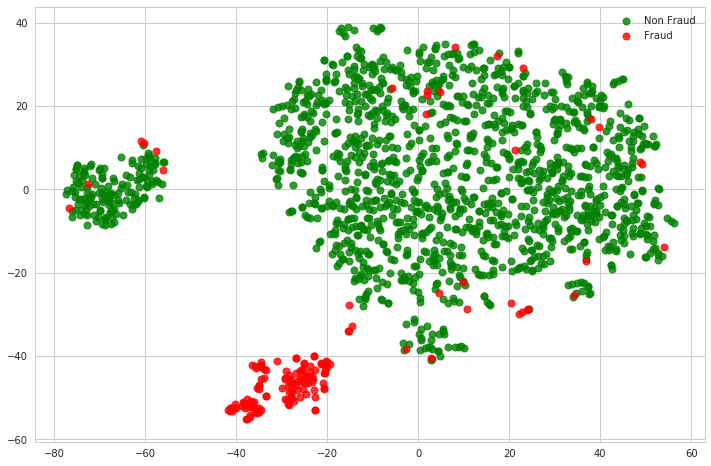

In [96]:
tsne_plot(test_rep_x, y_test)

### How our Logistic Regression Sees it

shape of X_t is now (1648, 2), reduced from 31 variables to just 2


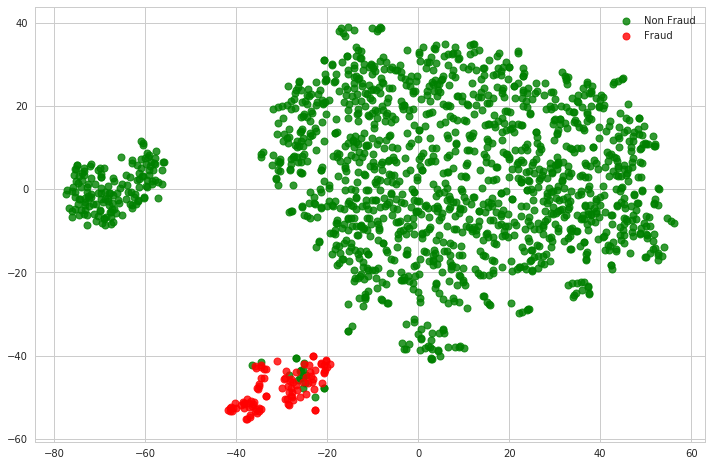

In [101]:
tsne_plot(test_rep_x, pred_y_test)